In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import qudipy.circuit as circ
import qudipy.potential as pot
import qudipy.qutils as qt
import qudipy.utils.helpers as hp

import qudipy.starkshift as ss
from qudipy.utils.constants import Constants

from scipy.interpolate import interp1d
import numpy as np

csts = Constants('Si/SiO2')

# pot_dir = os.path.join(sys.path[0], 'QuDiPy tutorial data','Nextnano simulations','TMPLATE_5Gate_1.358E15_noRGrind')

input_nextnano = os.path.join(sys.path[0], 'QuDiPy tutorial data','Nextnano simulations','TMPLATE_5Gate_1.358E15_noRGrind')
output_preprocessed = os.path.join(sys.path[0],'QuDiPy tutorial data','Pre-processed potentials','Pre-processed_data')

#importing potential
potential = pot.process_nextnano.import_dir(input_nextnano, show_files=True)

# Desired Slice
z = 0.45

_, nearest_slice = hp.find_nearest(potential[0]['coord']['z'], z)

print(f'The nearest slice for z = {z} is: {nearest_slice}')
#specifying control values and names
pot_dir = output_preprocessed + '_for_nearest_slice{:.3e}'.format(nearest_slice) + '/'

ctrl_names = ['V1','V2','V3','V4','V5']
ctrl_vals = pot.process_nextnano.get_ctrl_vals(potential) # Must make sure that ctrl_vals are sorted
ctrl_vals


Importing .coord data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.200_V5_0.100:
Importing .dat data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.200_V5_0.100:
Importing .coord data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.220_V5_0.100:
Importing .dat data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.220_V5_0.100:
Importing .coord data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.260_V5_0.100:
Importing .dat data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.260_V5_0.100:
Importing .coord data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.240_V5_0.100:
Importing .dat data files from /TEMPLATE_5Gate_Dop_1.358E15_noRGrid_V1_0.100_V2_0.200_V3_0.200_V4_0.240_V5_0.100:
The nearest slice for z = 0.45 is: 0.4


[[0.1], [0.2], [0.2], [0.2, 0.22, 0.24, 0.26], [0.1]]

SAVE SUCCESS: Converting 3D nextnano simulation data to 2D XY-plane potential along slice for z = 0.4.
SAVE SUCCESS: Converting 3D nextnano simulation data to 2D XY-plane field along slice for z = 0.4.


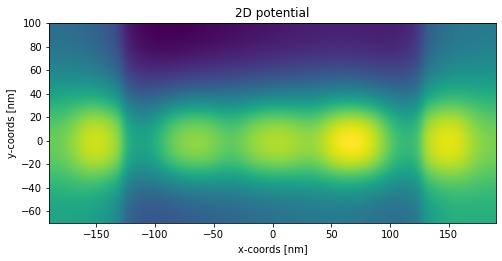

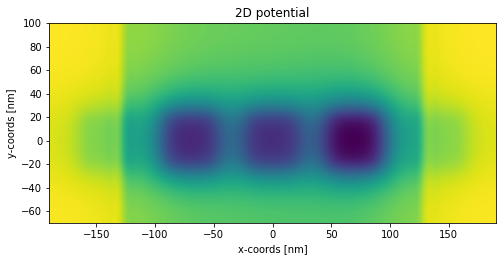

ValueError: x and y arrays must be equal in length along interpolation axis.

In [2]:

# Now we define the field types we wish to write 2D slices for. Either potential or the electric field.
pot.process_nextnano.write_data(input_nextnano,output_preprocessed, slice=z, f_type=['potential','field'])

loaded_data_pot = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='pot', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='eV')

loaded_data_field = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='electric', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='V/nm')

potential_int = pot.build_interpolator(loaded_data_pot,
                                         constants=csts)
e_field_int = pot.build_interpolator(loaded_data_field,
                                         constants=csts)

vg = [0.1,0.2,0.2,0.2325,0.1]

potential_int.plot(vg)
e_field_int.plot(vg)



_2d_coords = loaded_data_pot['coords']
gparams = pot.GridParameters(_2d_coords.x, _2d_coords.y)
len(loaded_data_pot['potentials'])

def true_g_data(grapams, pot_data, e_field_data):
    delta_g_vals = []
    for idx, param in enumerate(pot_data['ctrl_vals']):
        new_pot = pot_data['potentials'][idx]
        gparams.update_potential(new_pot)
        _, e_vecs = qt.solvers.solve_schrodinger_eq(csts, gparams, n_sols=1)
        wf = e_vecs[:,:,0]
        stark_shift = ss.starkshift.StarkShift(gparams, csts)
            #lambda to do the g-factor of discrete data rather than interpolated

        dummy_e_int = lambda V: e_field_data['electric'][
                        np.nonzero(np.array(ctrl_vals[0]) == V[0])[0][0]]

        dg = stark_shift.delta_g(dummy_e_int, [param], ctrl_names,
                                             wavefuncs=[wf])['delta_g_1'][0]
        delta_g_vals.append(dg)
    return interp1d(np.array(ctrl_vals[0]), np.sort(delta_g_vals))


delta_g_true = true_g_data(gparams, loaded_data_pot, loaded_data_field)
